In [1]:
import scipy.io
from scipy.stats import skew, kurtosis
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, time
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
file_lists = [x for x in Path(r"C:\Users\engin\OneDrive\Desktop\WindTurbineHighSpeedBearingPrognosis-Data-main").iterdir() if x.parts[-1].endswith('.mat')]


all_vibration_data = []

for file in sorted(file_lists):
    data = scipy.io.loadmat(file)
    file_name = file.parts[-1]
    date = datetime.strptime(file_name.split('-')[1][:8], "%Y%m%d")
    vibration_data = {'date':date, 'vibration': data['vibration'].flatten()} 
    all_vibration_data.append(vibration_data)




In [3]:
all_vibration_data[16]

{'date': datetime.datetime(2013, 3, 23, 0, 0),
 'vibration': array([0.46018714, 1.15721142, 0.62046999, ..., 0.80812097, 1.03865755,
        1.07374132])}

# Plot the entire vibrartion signal

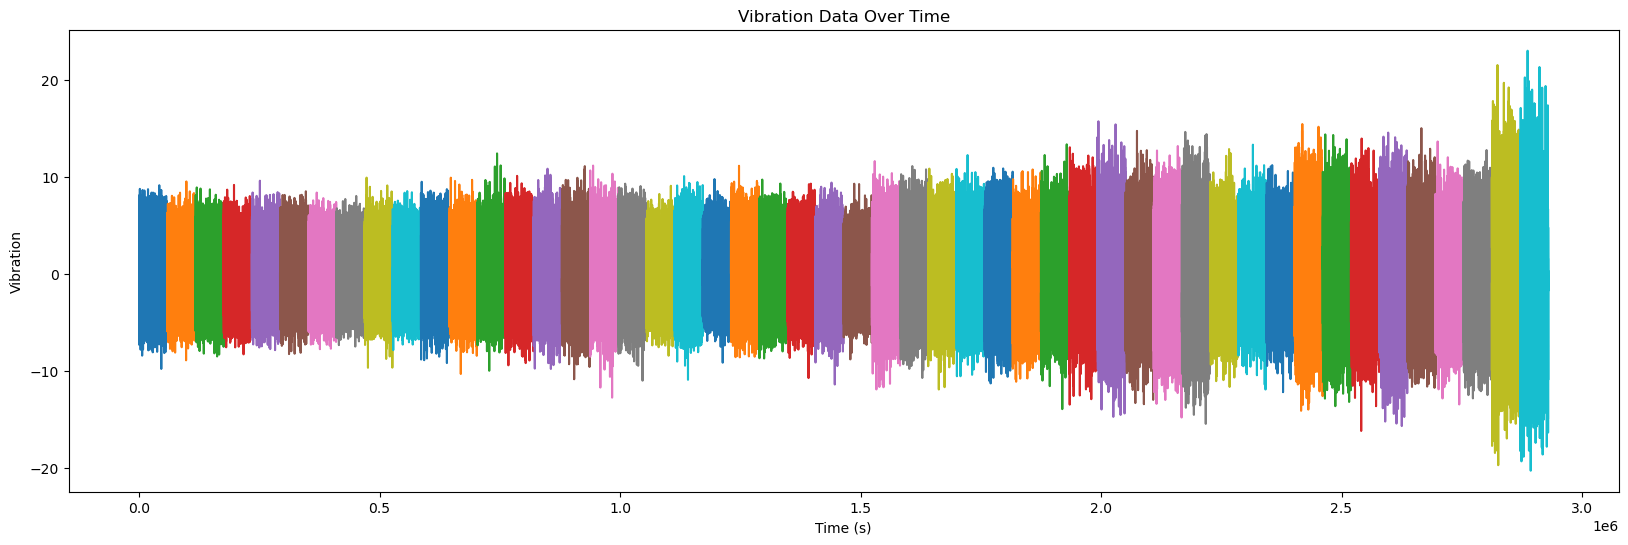

In [5]:
t_start=0

plt.figure(figsize=(20, 6))
for vd in all_vibration_data:
    date = vd['date']
    vibration = vd['vibration'][::10]  # downsample by 10
    t = t_start + np.arange(len(vibration)) 
    t_start = t[-1] + 1  # update start time for next data segment
    plt.plot(t, vibration, label=date.strftime('%Y-%m-%d'))
plt.xlabel('Time (s)')
plt.ylabel('Vibration')
plt.title('Vibration Data Over Time')
# plt.legend()
plt.show()
    

# Extract time-domain and frequency domain features

In [7]:
SAMPLING_FREQUENCY = 97656
SEGMENT_DURATION = 6
FFT_WINDOW_SIZE = 128
ROLLING_WINDOW_SIZE = 5

In [8]:

fs = SAMPLING_FREQUENCY
window_size = FFT_WINDOW_SIZE

feature_rows = []

for vd in all_vibration_data:
    signal = np.array(vd['vibration'])
    date = vd['date']
    
    # Time-domain features
    time_features = {
        'Mean': np.mean(signal),
        'Std': np.std(signal),
        'Skewness': skew(signal),
        'Kurtosis': kurtosis(signal, fisher=False),
        'Peak2Peak': np.ptp(signal),
        'RMS': np.sqrt(np.mean(signal ** 2)),
        'CrestFactor': np.max(np.abs(signal)) / np.sqrt(np.mean(signal ** 2)),
        'Energy': np.sum(signal ** 2),
    }

    # Spectral kurtosis features
    f, t, Zxx = stft(signal, fs=fs, nperseg=window_size, noverlap=window_size // 2)
    Pxx = np.abs(Zxx) ** 2
    sk = (np.mean((Pxx - np.mean(Pxx, axis=1, keepdims=True))**4, axis=1) /
          (np.var(Pxx, axis=1)**2 + 1e-10)) - 3
    sk_features = {
        'SKMean': np.mean(sk),
        'SKStd': np.std(sk),
        'SKSkewness': skew(sk),
        'SKKurtosis': kurtosis(sk, fisher=False),
    }

    # Combine features and add date
    all_features = {'Date': date, **time_features, **sk_features}
    feature_rows.append(all_features)

# Create DataFrame
df = pd.DataFrame(feature_rows)

# Save to CSV if needed
df.to_csv("vibration_features.csv", index=False)

In [9]:
df

,Date,Mean,Std,Skewness,Kurtosis,Peak2Peak,RMS,CrestFactor,Energy,SKMean,SKStd,SKSkewness,SKKurtosis
0,2013-03-07,0.346052,2.270481,0.003870,2.995612,21.621068,2.296702,4.914735,3.090718e+06,4.124758,2.152320,-1.112032,3.826583
1,2013-03-08,0.244092,2.062146,0.003010,3.019457,19.309907,2.076542,4.912863,2.526572e+06,4.375711,2.203413,-1.146890,4.177648
2,2013-03-09,0.218729,2.103553,-0.001029,3.022396,21.474075,2.114894,5.214330,2.620761e+06,4.502894,2.398670,-0.805974,3.518785
3,2013-03-10,0.213717,2.008063,0.001477,3.041457,19.520002,2.019404,5.286041,2.389443e+06,4.561448,2.475301,-0.554593,4.021284
4,2013-03-11,0.215185,2.060562,0.001012,3.044474,21.216959,2.071768,5.235226,2.514967e+06,4.657451,2.256947,-1.162151,4.087304
5,2013-03-12,0.293353,2.079127,-0.008428,3.017996,20.049853,2.099721,4.796572,2.583290e+06,4.305361,2.387033,-0.803092,3.170046
6,2013-03-13,0.212930,1.971981,-0.001429,3.017409,18.836983,1.983443,4.849649,2.305099e+06,4.498131,2.209050,-1.039830,4.526018
7,2013-03-14,0.244005,1.811428,0.002216,3.005747,17.861651,1.827789,4.908489,1.957502e+06,4.347521,2.203700,-0.823130,4.188178
8,2013-03-15,0.209835,1.997331,0.001559,3.071082,21.120432,2.008323,5.432289,2.363292e+06,4.556082,2.325751,-0.973522,4.073831
9,2013-03-16,0.233177,1.984203,-0.001959,3.007174,18.831975,1.997857,5.048283,2.338725e+06,4.479917,2.341916,-0.690574,4.121389


# Remove noise from the data

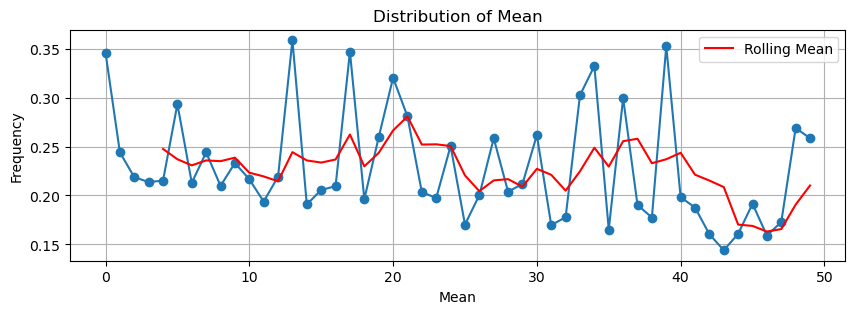

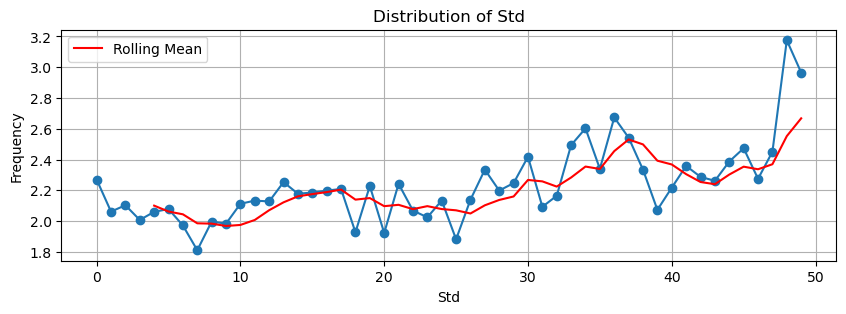

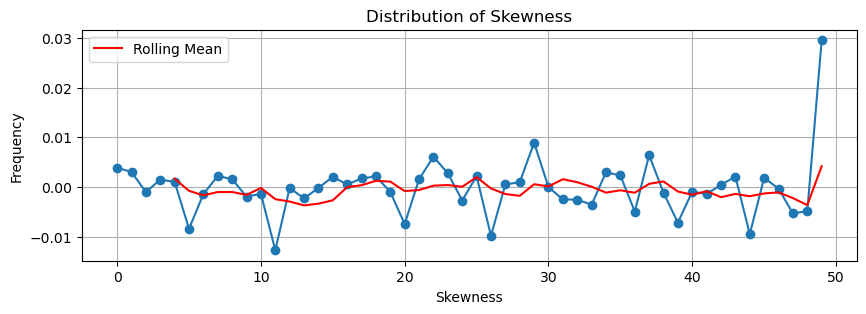

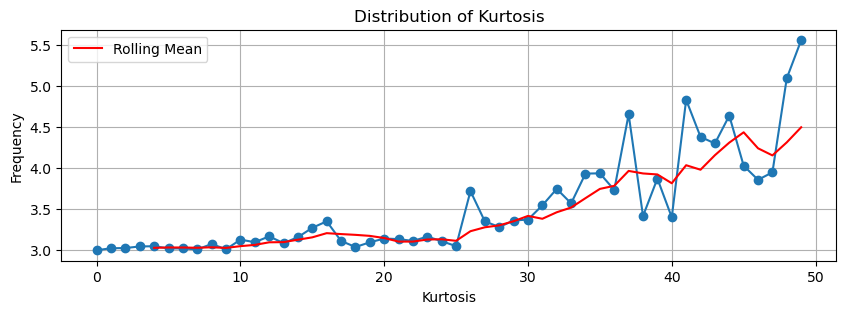

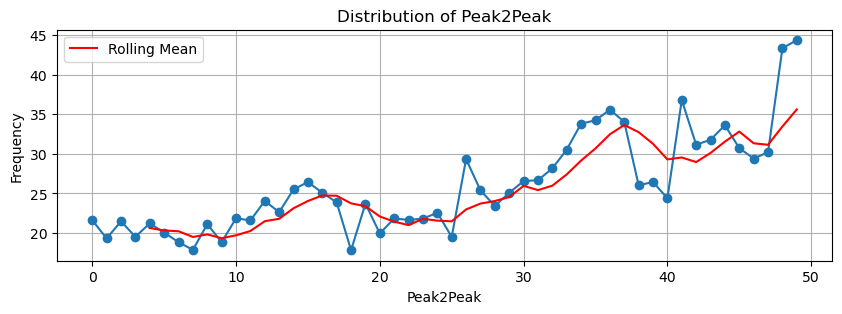

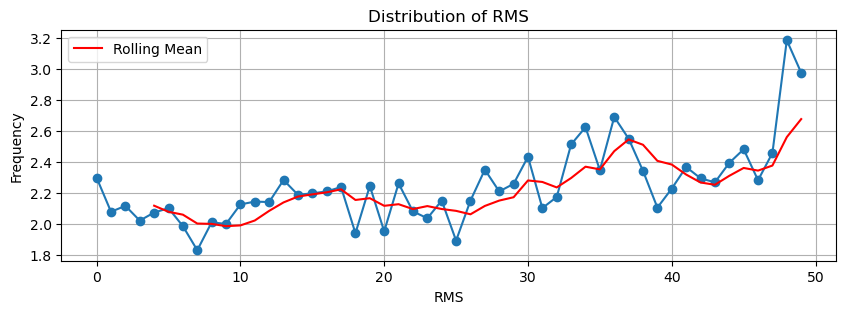

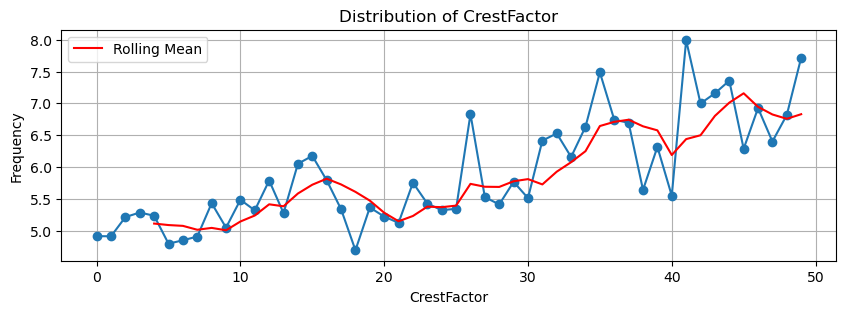

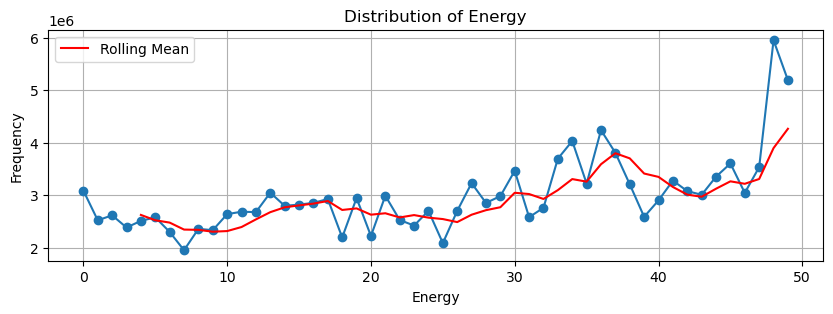

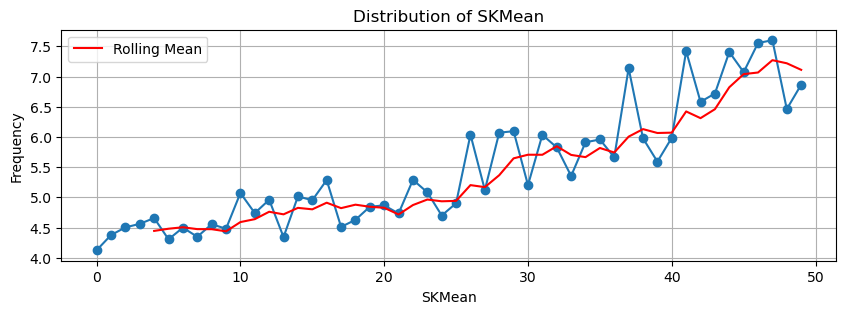

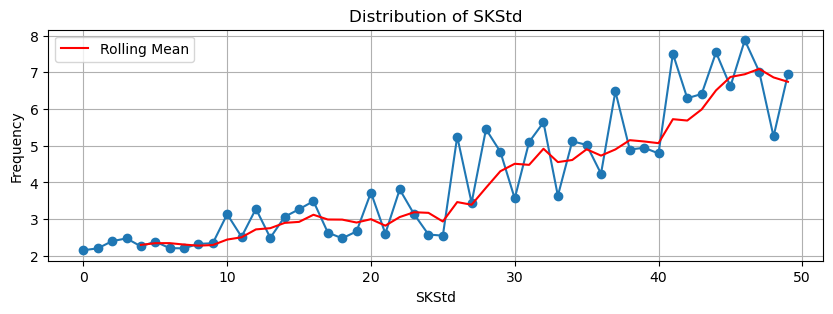

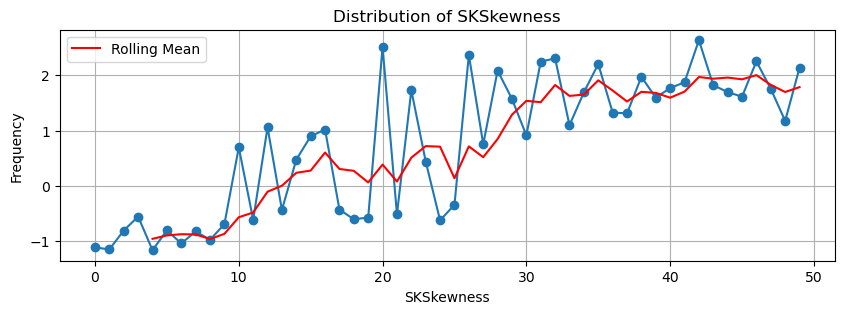

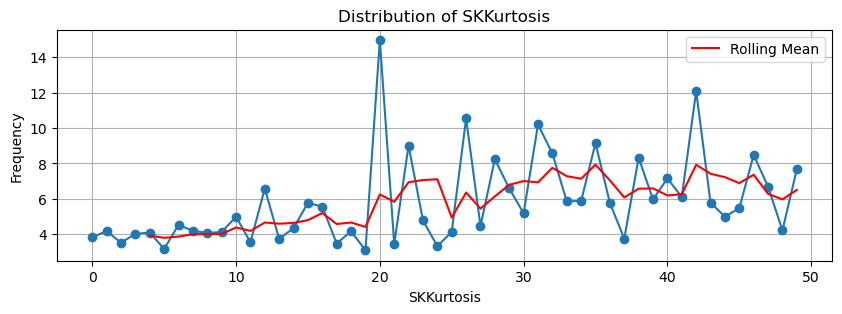

In [11]:
for col in df.columns[1:]:
    plt.figure(figsize=(10, 3))
    plt.plot(df[col], marker='o', linestyle='-')
    plt.plot(df[col].rolling(ROLLING_WINDOW_SIZE).mean(), color='red', label='Rolling Mean')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
df_rolling = df.copy()
# Rolling window features
for col in df.columns[1:]:
    df_rolling[col] = df_rolling[col].rolling(window=ROLLING_WINDOW_SIZE).mean()

df_rolling.dropna(inplace=True)
# # Save to CSV if needed
df_rolling.to_csv("vibration_features_smooth.csv", index=False)

# Divide into Train and Test

In [14]:
# Helper function
def calculate_monotonicity(df: pd.DataFrame) -> pd.Series:
    scores = {}
    n = len(df)
    for col in df.columns :
        if col != 'Date':
            diffs = df[col].diff().dropna()
            pos = (diffs > 0).sum()
            neg = (diffs < 0).sum()
            scores[col] = abs(pos - neg) / (n - 1)
    return pd.Series(scores).sort_values(ascending=False)

def obtain_HI(train_df,test_df):


    scaler = StandardScaler()
    pca = PCA(n_components=2)
    
    train_scaled = scaler.fit_transform(train_df)
    # Apply PCA to reduce to 2D
    train_pca = pca.fit_transform(train_scaled)

    # Transform test data using the same scaler and PCA
    test_scaled = scaler.transform(test_df)
    test_pca = pca.transform(test_scaled)


    return train_pca[:, 0],test_pca[:, 0], scaler, pca

In [15]:
df = pd.read_csv("vibration_features_smooth.csv")

train_time = 38 # should be less than 45

train_df = df.loc[0:train_time,:] #
train_df['random'] = np.random.rand(len(train_df))
test_df = df.loc[train_time:,:] 

C:\Users\engin\AppData\Local\Temp\ipykernel_15548\3367845590.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['random'] = np.random.rand(len(train_df))


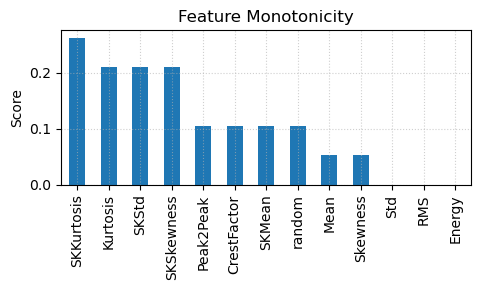

In [16]:
importance = calculate_monotonicity(train_df)
importance.plot(kind='bar', figsize=(5, 3), title='Feature Monotonicity')
plt.ylabel("Score"); plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [17]:
selected_cols =  importance.sort_values(ascending=False)[:5].index.tolist()
train_selected = train_df[selected_cols]
test_selected = test_df[selected_cols]

In [18]:
train_hi,test_hi, scaler, pca = obtain_HI(train_selected,test_selected)
# Time indices
t_train = np.arange(len(train_hi))
t_test = np.arange(len(train_hi), len(train_hi) + len(test_hi))

# A simple neural network

Train MSE: 0.8819 || Test MSE: 0.2855


C:\Users\engin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


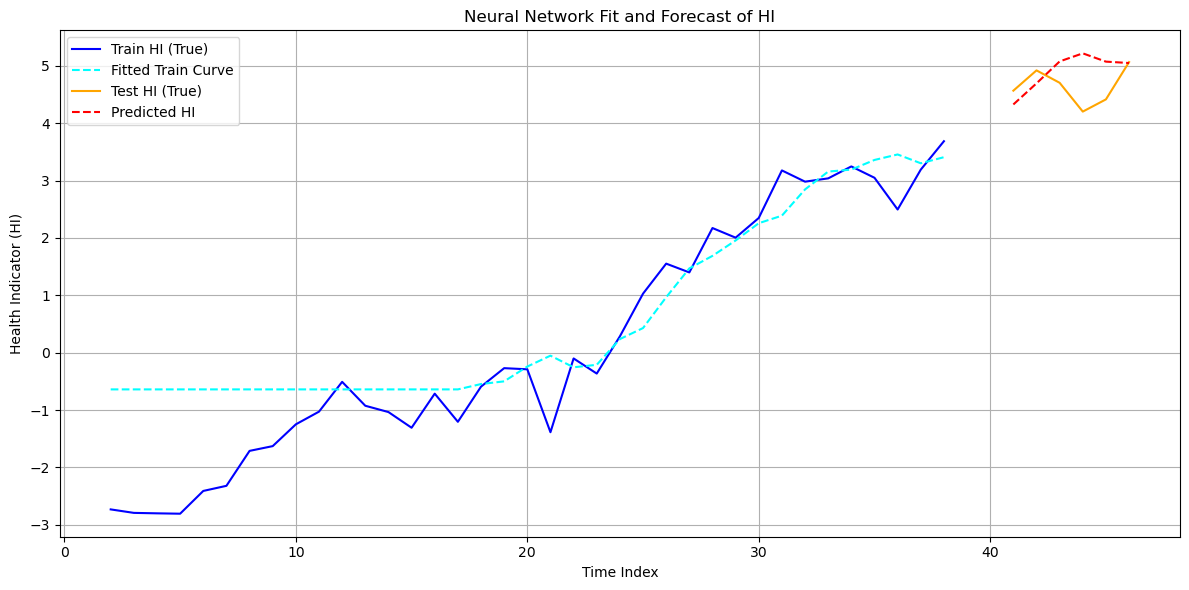

In [20]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to prepare features and targets for time series forecasting
def prepare_data(train_hi, t_train):
    """
    Constructs a supervised learning dataset where each input sample consists of:
        - HI value at time t-1
        - HI value at time t
        - Time index t-1
        - Time index t
    and the target is the HI value at time t+1.
    
    Parameters:
    - train_hi: 1D array of Health Indicator values
    - t_train: 1D array of time indices
    
    Returns:
    - X: Feature matrix (N x 4)
    - y: Target vector (N,)
    """
    # Ensure inputs are flattened arrays
    train_hi = np.array(train_hi).flatten()
    t_train = np.array(t_train).flatten()

    X = []  # Feature list
    y = []  # Target list

    # Iterate through data to build samples
    for i in range(2, len(train_hi)):
        features = [
            train_hi[i - 2],  # HI at t-1
            train_hi[i - 1],  # HI at t
            t_train[i - 2],   # Time at t-1
            t_train[i - 1]    # Time at t
        ]
        target = train_hi[i]  # HI at t+1 (to be predicted)

        X.append(features)
        y.append(target)

    return np.array(X), np.array(y)

# Prepare training and testing datasets using sliding window features
X_train, y_train = prepare_data(train_hi, t_train)
X_test, y_test = prepare_data(test_hi, t_test)

# Define and train the neural network model
# Architecture: 2 hidden layers with 6 and 3 neurons respectively
model = MLPRegressor(hidden_layer_sizes=(6, 3), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict HI for both training and testing data
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Evaluate performance using Mean Squared Error (MSE)
train_mse = mean_squared_error(train_pred, y_train)
test_mse = mean_squared_error(test_pred, y_test)
print(f"Train MSE: {train_mse:.4f} || Test MSE: {test_mse:.4f}")

# Visualization of true vs predicted HI values
plt.figure(figsize=(12, 6))

# Plot true and predicted HI values for training data
plt.plot(t_train[2:], y_train, label='Train HI (True)', color='blue')
plt.plot(t_train[2:], train_pred, label='Fitted Train Curve', color='cyan', linestyle='--')

# Plot true and predicted HI values for test data
plt.plot(t_test[2:], y_test, label='Test HI (True)', color='orange')
plt.plot(t_test[2:], test_pred, label='Predicted HI', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Time Index')
plt.ylabel('Health Indicator (HI)')
plt.title('Neural Network Fit and Forecast of HI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Polynomial fitting

Train MSE: 0.2959 || Test MSE: 0.1737


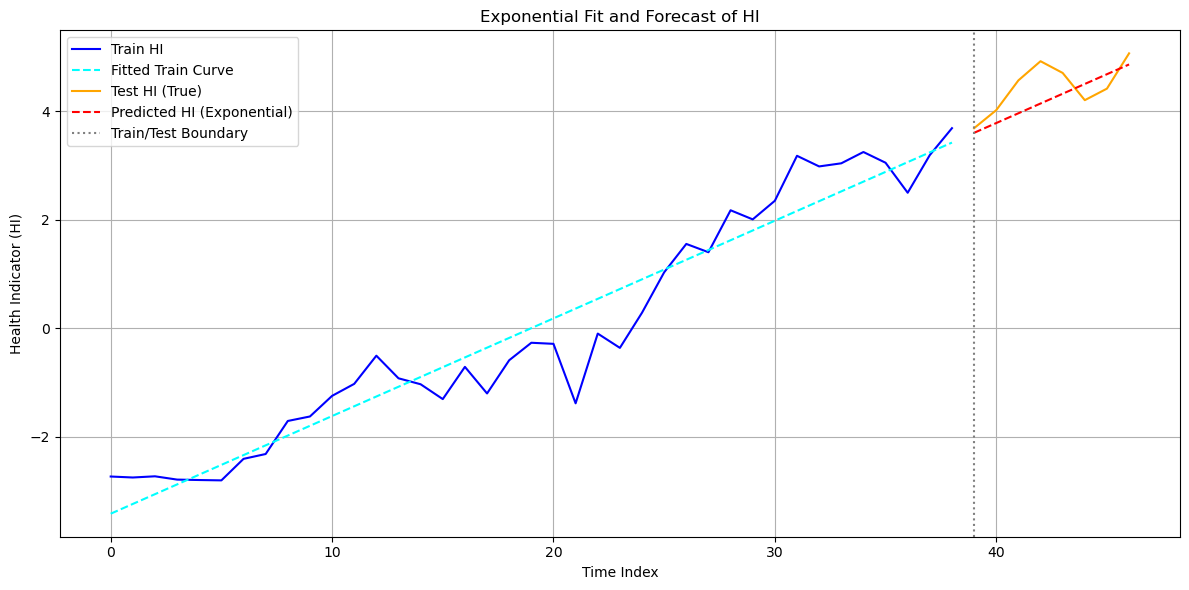

In [22]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error



# Exponential model function
# def polynomial_func(t, a, b, c,d):
#     return a  *(t ** 3) + b*(t**2) + c*t + d

def polynomial_func(t,c,d):
    return  c*t + d

# def polynomial_func(t,  b, c,d):
#     return b*(t**2) + c*t + d

# def polynomial_func(t, a, b, c):
#     return a * np.exp(b * t) + c

# Fit the exponential curve to train_hi
popt, _ = curve_fit(polynomial_func, t_train, train_hi, maxfev=10000)  # a, b, c

# Predict future HI
train_pred = polynomial_func(t_train, *popt)
test_pred = polynomial_func(t_test, *popt)

# Compute MSE for training and test sets
train_mse = mean_squared_error(train_hi, train_pred)
test_mse = mean_squared_error(test_hi, test_pred)
print(f"Train MSE: {train_mse:.4f} || Test MSE: {test_mse:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t_train, train_hi, label='Train HI', color='blue')
plt.plot(t_train, train_pred, label='Fitted Train Curve', color='cyan', linestyle='--')
plt.plot(t_test, test_hi, label='Test HI (True)', color='orange')
plt.plot(t_test, test_pred, label='Predicted HI (Exponential)', color='red', linestyle='--')
plt.axvline(len(train_hi), color='gray', linestyle=':', label='Train/Test Boundary')
plt.xlabel('Time Index')
plt.ylabel('Health Indicator (HI)')
plt.title('Exponential Fit and Forecast of HI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Using ARIMA model

C:\Users\engin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\engin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\engin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\engin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Train MSE: 0.0526 || Test MSE: 0.2997


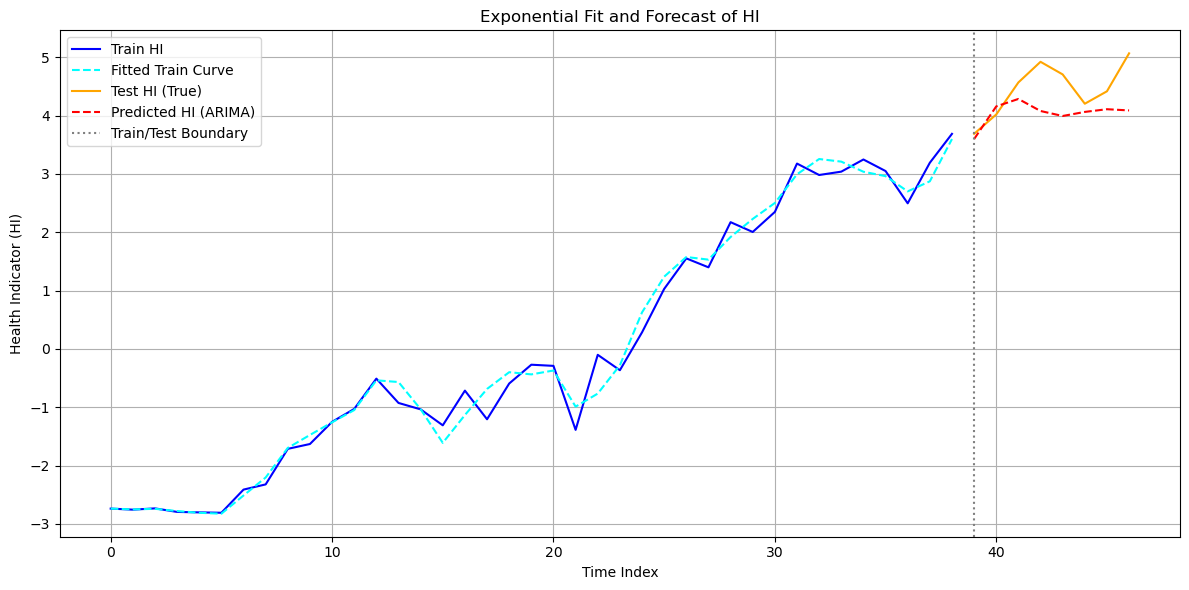

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_hi, order=(2, 1, 2))  # (p,d,q) # Change these values to find the best fit
fitted_model = model.fit()
# Forecast
# In-sample predictions (aligned to the *original scale* of train_hi)
train_pred = fitted_model.predict(start=1, end=len(train_hi), typ='levels')
# Out-of-sample forecast
test_pred = fitted_model.forecast(steps=len(test_hi))

# Compute MSE for training and test sets
train_mse = mean_squared_error(train_hi, train_pred)
test_mse = mean_squared_error(test_hi, test_pred)
print(f"Train MSE: {train_mse:.4f} || Test MSE: {test_mse:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t_train, train_hi, label='Train HI', color='blue')
plt.plot(t_train, train_pred, label='Fitted Train Curve', color='cyan', linestyle='--')
plt.plot(t_test, test_hi, label='Test HI (True)', color='orange')
plt.plot(t_test, test_pred, label='Predicted HI (ARIMA)', color='red', linestyle='--')
plt.axvline(len(train_hi), color='gray', linestyle=':', label='Train/Test Boundary')
plt.xlabel('Time Index')
plt.ylabel('Health Indicator (HI)')
plt.title('Exponential Fit and Forecast of HI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prophet model

22:04:47 - cmdstanpy - INFO - Chain [1] start processing
22:04:47 - cmdstanpy - INFO - Chain [1] done processing


Train MSE: 0.2835 || Test MSE: 0.1976


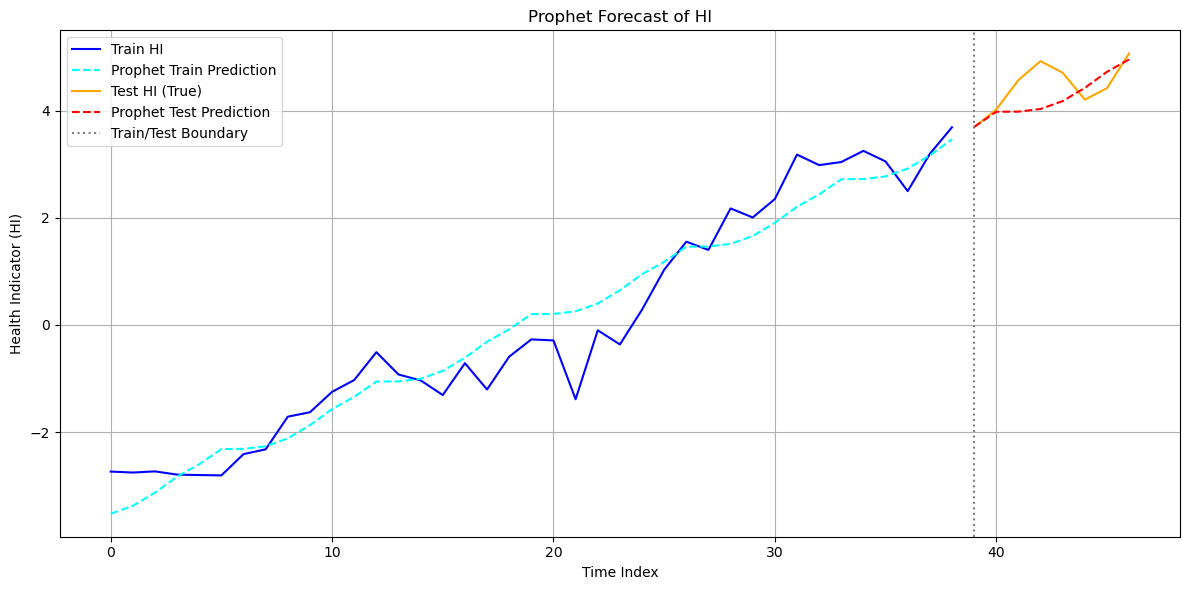

In [26]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#train_hi, test_hi, t_train, t_test, scaler, pca = prepare_HI(train_time=25) # obtain the intital values for PCA and scaler as they should not be changing

# Prepare data for Prophet
train_df = pd.DataFrame({
    'ds': pd.date_range(start='2020-01-01', periods=len(t_train), freq='D'),
    'y': train_hi
})

test_df = pd.DataFrame({
    'ds': pd.date_range(start=train_df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=len(t_test), freq='D'),
    'y': test_hi
})

# Fit Prophet model
model = Prophet()
model.fit(train_df)

# Create future dataframe for prediction
future = pd.concat([train_df[['ds']], test_df[['ds']]])
forecast = model.predict(future)

# Extract predictions
train_pred = forecast.loc[:len(train_df)-1, 'yhat'].values
test_pred = forecast.loc[len(train_df):, 'yhat'].values

# Compute MSE for training and test sets
train_mse = mean_squared_error(train_hi, train_pred)
test_mse = mean_squared_error(test_hi, test_pred)
print(f"Train MSE: {train_mse:.4f} || Test MSE: {test_mse:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t_train, train_hi, label='Train HI', color='blue')
plt.plot(t_train, train_pred, label='Prophet Train Prediction', color='cyan', linestyle='--')
plt.plot(t_test, test_hi, label='Test HI (True)', color='orange')
plt.plot(t_test, test_pred, label='Prophet Test Prediction', color='red', linestyle='--')
plt.axvline(len(train_hi), color='gray', linestyle=':', label='Train/Test Boundary')
plt.xlabel('Time Index')
plt.ylabel('Health Indicator (HI)')
plt.title('Prophet Forecast of HI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

